## EDA Olist Brazilian E-Commerce

Notebook này thực hiện **khám phá dữ liệu (EDA)** cho bộ dữ liệu Olist Brazilian E-Commerce.

### Mô tả các bảng chính
- **Customers (`olist_customers_dataset`)**: Thông tin khách hàng và vị trí. Mỗi đơn hàng có một `customer_id` (không duy nhất theo khách), trong khi `customer_unique_id` dùng để nhận diện khách hàng thật sự (phục vụ phân tích mua lại).
- **Geolocation (`olist_geolocation_dataset`)**: Thông tin mã bưu điện (zip code) của Brazil và toạ độ `lat/lng`. Dùng để vẽ bản đồ và tính khoảng cách giữa **người bán** và **khách hàng**.
- **Orders (`olist_orders_dataset`)**: Bảng lõi chứa thông tin đơn hàng, dùng làm điểm nối đến các bảng khác (items, payments, reviews, customers,...).
- **Order Items (`olist_order_items_dataset`)**: Chi tiết từng sản phẩm trong đơn hàng (mỗi dòng là 1 item). Chứa giá sản phẩm, phí vận chuyển (freight), liên kết đến `orders`, `products` và `sellers`.
- **Payments (`olist_order_payments_dataset`)**: Thông tin phương thức thanh toán và số lần trả góp cho từng đơn hàng.
- **Order Reviews (`olist_order_reviews_dataset`)**: Đánh giá của khách hàng sau khi nhận hàng hoặc khi hết hạn giao dự kiến. Gồm điểm số (`review_score`) và nhận xét văn bản.
- **Products (`olist_products_dataset`)**: Thông tin sản phẩm được bán (kích thước, trọng lượng, danh mục,...).
- **Sellers (`olist_sellers_dataset`)**: Thông tin người bán thực hiện đơn hàng, bao gồm vị trí dùng để phân tích logistics.
- **Category Name Translation (`product_category_name_translation`)**: Dịch tên danh mục sản phẩm từ tiếng Bồ Đào Nha sang tiếng Anh.

In [ ]:
# Import thư viện và cấu hình

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Thư mục chứa dữ liệu raw (tương đối so với notebook này)
DATA_DIR = os.path.join("..", "..", "data", "raw")

datasets_info = {
    "customers": "olist_customers_dataset.csv",
    "geolocation": "olist_geolocation_dataset.csv",
    "order_items": "olist_order_items_dataset.csv",
    "order_payments": "olist_order_payments_dataset.csv",
    "order_reviews": "olist_order_reviews_dataset.csv",
    "orders": "olist_orders_dataset.csv",
    "products": "olist_products_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "category_translation": "product_category_name_translation.csv",
}

# Đọc toàn bộ các bảng với tqdm để theo dõi tiến độ
dfs = {}
for name, filename in tqdm(datasets_info.items(), desc="Đọc các bảng CSV"):
    path = os.path.join(DATA_DIR, filename)
    dfs[name] = pd.read_csv(path)

{key: df.shape for key, df in dfs.items()}


In [ ]:
# Tổng quan kích thước, thiếu dữ liệu, trùng lặp của từng bảng

summary_rows = []

for name, df in tqdm(dfs.items(), desc="Tổng hợp thông tin bảng"):
    n_rows, n_cols = df.shape
    n_missing = df.isna().sum().sum()
    pct_missing = 100 * n_missing / (n_rows * n_cols)
    n_duplicates = df.duplicated().sum()
    mem_mb = df.memory_usage(deep=True).sum() / 1e6

    summary_rows.append(
        {
            "dataset": name,
            "n_rows": n_rows,
            "n_cols": n_cols,
            "memory_mb": round(mem_mb, 2),
            "n_missing": int(n_missing),
            "pct_missing": round(pct_missing, 2),
            "n_duplicates": int(n_duplicates),
        }
    )

summary_df = pd.DataFrame(summary_rows).sort_values("memory_mb", ascending=False)
summary_df


In [4]:
# Chuẩn hoá một số kiểu dữ liệu quan trọng

orders = dfs["orders"].copy()

# Chuyển đổi cột thời gian về kiểu datetime
datetime_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

for col in datetime_cols:
    if col in orders.columns:
        orders[col] = pd.to_datetime(orders[col])

orders["order_purchase_date"] = orders["order_purchase_timestamp"].dt.date
orders["order_purchase_month"] = orders["order_purchase_timestamp"].dt.to_period("M")

orders.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,order_purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-02,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07-24,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11-18,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02-13,2018-02


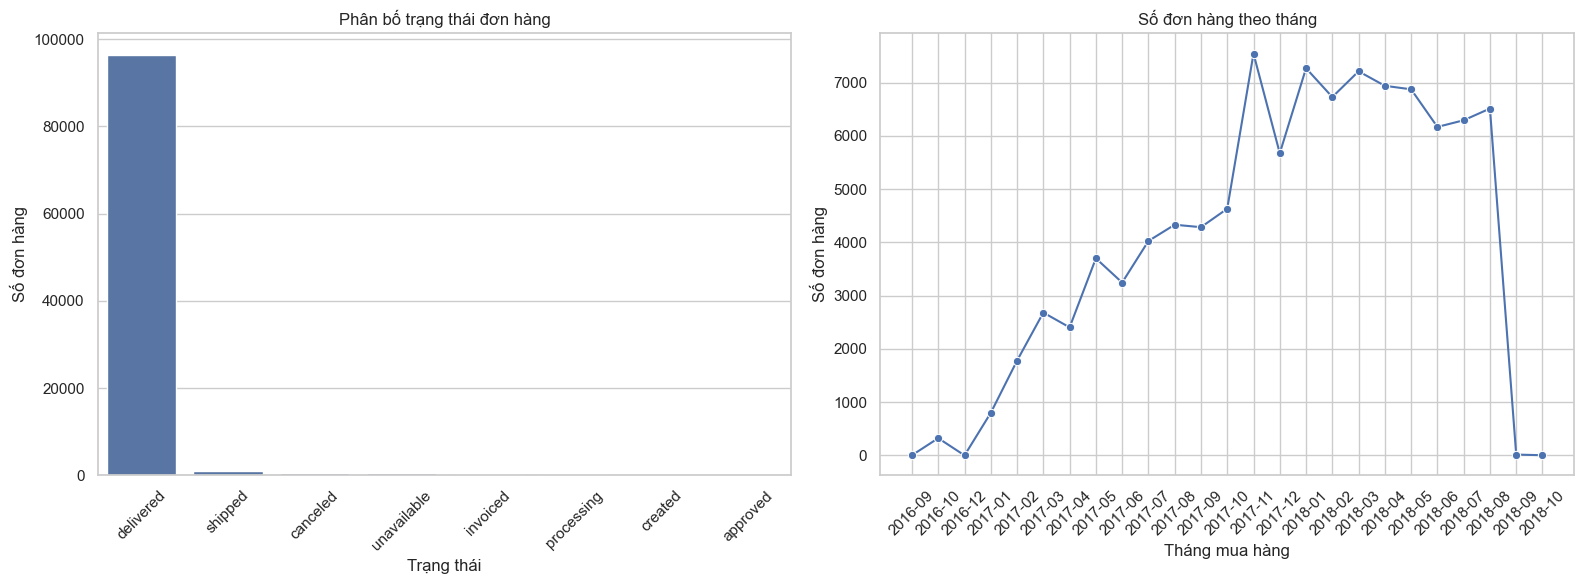

In [5]:
# Phân bố trạng thái đơn hàng và đơn hàng theo thời gian

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Phân bố trạng thái đơn hàng
sns.countplot(
    data=orders,
    x="order_status",
    order=orders["order_status"].value_counts().index,
    ax=axes[0],
)
axes[0].set_title("Phân bố trạng thái đơn hàng")
axes[0].set_xlabel("Trạng thái")
axes[0].set_ylabel("Số đơn hàng")
axes[0].tick_params(axis="x", rotation=45)

# Số đơn hàng theo tháng
orders_per_month = (
    orders.groupby("order_purchase_month")["order_id"]
    .nunique()
    .reset_index(name="n_orders")
)
orders_per_month["order_purchase_month"] = orders_per_month[
    "order_purchase_month"
].astype(str)

sns.lineplot(
    data=orders_per_month,
    x="order_purchase_month",
    y="n_orders",
    marker="o",
    ax=axes[1],
)
axes[1].set_title("Số đơn hàng theo tháng")
axes[1].set_xlabel("Tháng mua hàng")
axes[1].set_ylabel("Số đơn hàng")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


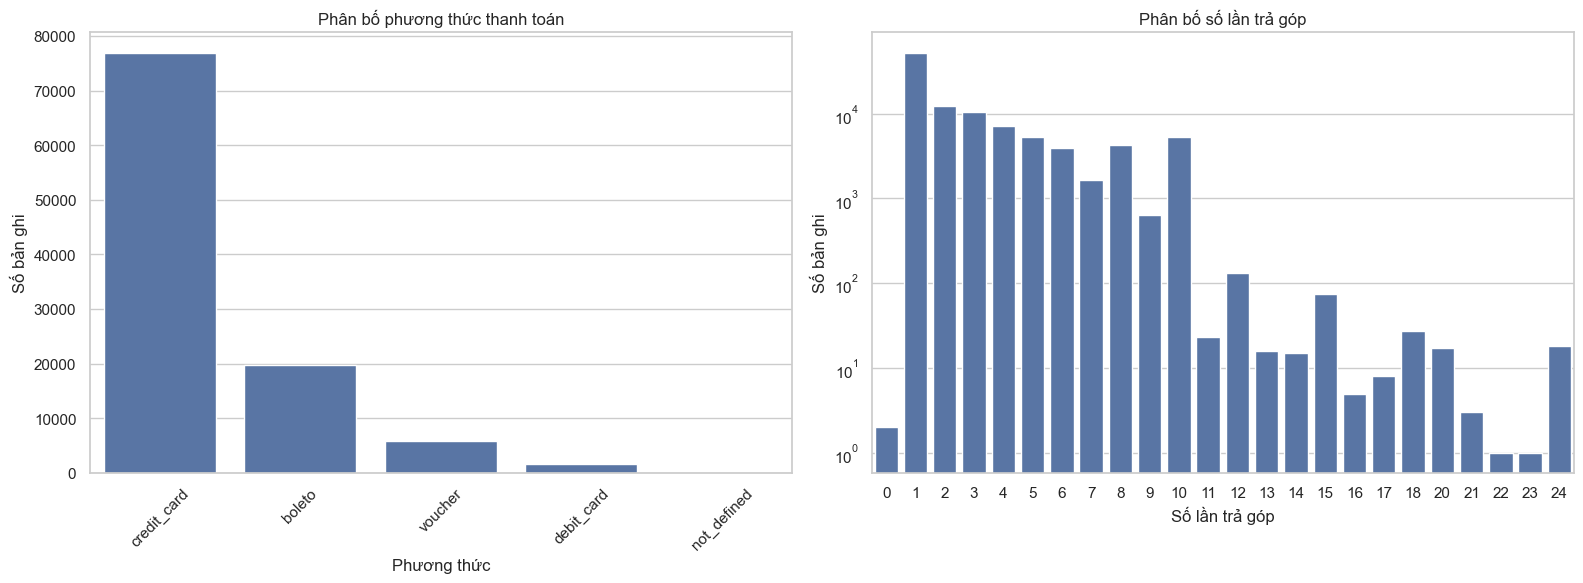

In [6]:
# Phân tích thanh toán: phương thức và số lần trả góp

payments = dfs["order_payments"].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Phân bố phương thức thanh toán
sns.countplot(
    data=payments,
    x="payment_type",
    order=payments["payment_type"].value_counts().index,
    ax=axes[0],
)
axes[0].set_title("Phân bố phương thức thanh toán")
axes[0].set_xlabel("Phương thức")
axes[0].set_ylabel("Số bản ghi")
axes[0].tick_params(axis="x", rotation=45)

# Phân bố số lần trả góp
sns.countplot(
    data=payments,
    x="payment_installments",
    ax=axes[1],
)
axes[1].set_title("Phân bố số lần trả góp")
axes[1].set_xlabel("Số lần trả góp")
axes[1].set_ylabel("Số bản ghi")
axes[1].set_yscale("log")  # log-scale để nhìn rõ hơn

plt.tight_layout()
plt.show()


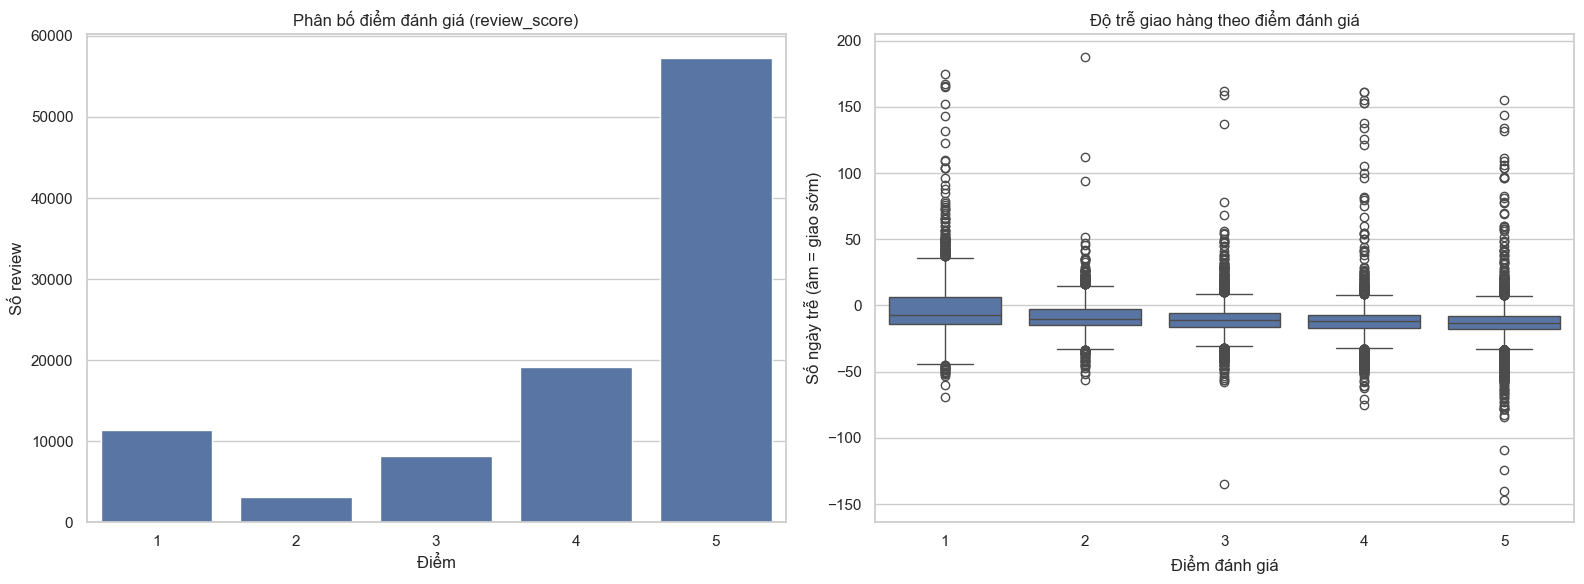

In [7]:
# Phân tích đánh giá: phân bố điểm review và mối quan hệ với thời gian giao hàng

reviews = dfs["order_reviews"].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Phân bố điểm review
sns.countplot(
    data=reviews,
    x="review_score",
    order=sorted(reviews["review_score"].dropna().unique()),
    ax=axes[0],
)
axes[0].set_title("Phân bố điểm đánh giá (review_score)")
axes[0].set_xlabel("Điểm")
axes[0].set_ylabel("Số review")

# Gộp review với orders để xem chênh lệch thời gian giao
reviews_orders = reviews.merge(
    orders[["order_id", "order_delivered_customer_date", "order_estimated_delivery_date"]],
    on="order_id",
    how="left",
)

for col in ["order_delivered_customer_date", "order_estimated_delivery_date"]:
    reviews_orders[col] = pd.to_datetime(reviews_orders[col])

reviews_orders["delivery_delay_days"] = (
    (reviews_orders["order_delivered_customer_date"] - reviews_orders["order_estimated_delivery_date"])
    .dt.days
)

sns.boxplot(
    data=reviews_orders,
    x="review_score",
    y="delivery_delay_days",
    ax=axes[1],
)
axes[1].set_title("Độ trễ giao hàng theo điểm đánh giá")
axes[1].set_xlabel("Điểm đánh giá")
axes[1].set_ylabel("Số ngày trễ (âm = giao sớm)")

plt.tight_layout()
plt.show()


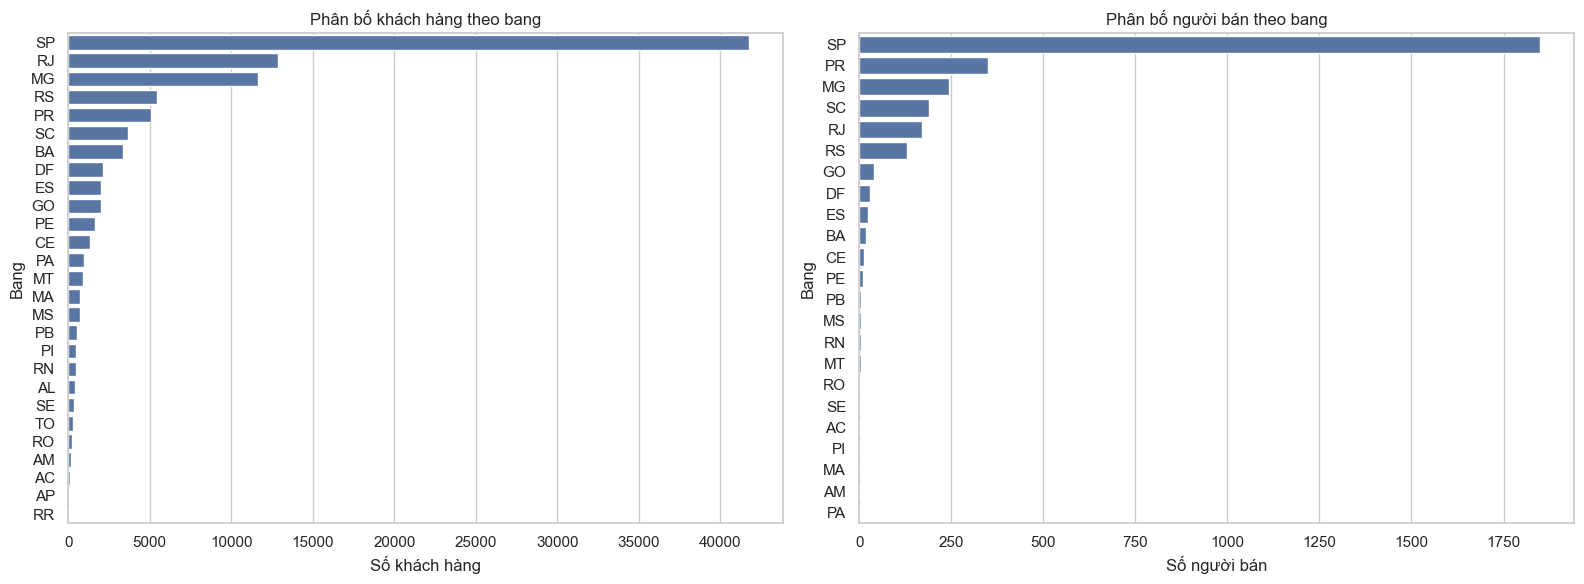

In [9]:
# Phân bố vị trí khách hàng và người bán theo bang (state)

customers = dfs["customers"].copy()
sellers = dfs["sellers"].copy()

cust_state_counts = (
    customers["customer_state"].value_counts().sort_values(ascending=False)
)
sel_state_counts = (
    sellers["seller_state"].value_counts().sort_values(ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    x=cust_state_counts.values,
    y=cust_state_counts.index,
    ax=axes[0],
)
axes[0].set_title("Phân bố khách hàng theo bang")
axes[0].set_xlabel("Số khách hàng")
axes[0].set_ylabel("Bang")

sns.barplot(
    x=sel_state_counts.values,
    y=sel_state_counts.index,
    ax=axes[1],
)
axes[1].set_title("Phân bố người bán theo bang")
axes[1].set_xlabel("Số người bán")
axes[1].set_ylabel("Bang")

plt.tight_layout()
plt.show()


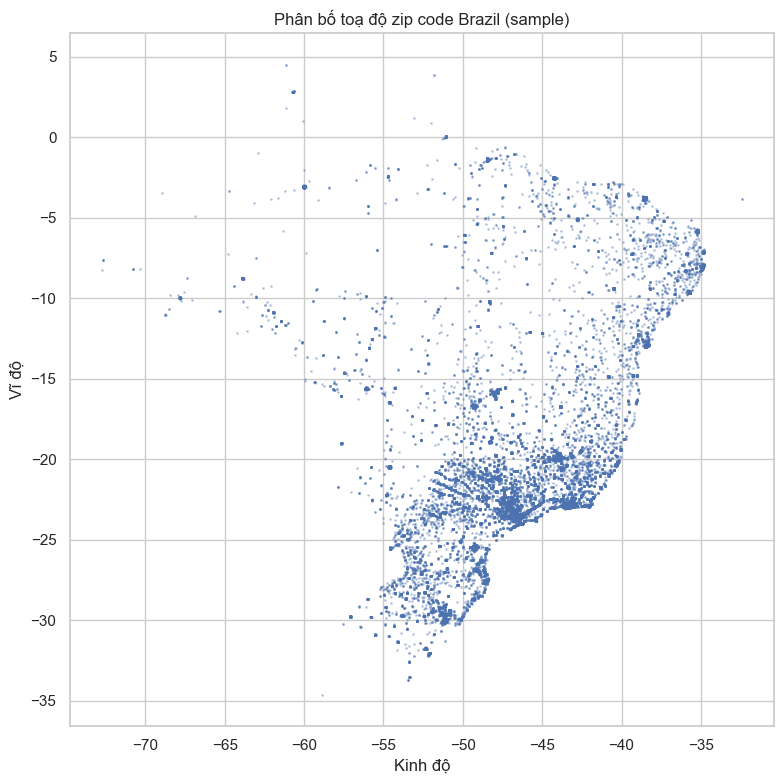

In [10]:
# Phân tích geo: scatter đơn giản các toạ độ (sample để vẽ nhanh)

geolocation = dfs["geolocation"].copy()

# Lấy mẫu để vẽ cho nhẹ (ví dụ 50k điểm nếu dữ liệu rất lớn)
geo_sample = geolocation.sample(
    n=min(50000, len(geolocation)), random_state=42
)

plt.figure(figsize=(8, 8))
plt.scatter(
    geo_sample["geolocation_lng"],
    geo_sample["geolocation_lat"],
    s=1,
    alpha=0.3,
)
plt.title("Phân bố toạ độ zip code Brazil (sample)")
plt.xlabel("Kinh độ")
plt.ylabel("Vĩ độ")
plt.tight_layout()
plt.show()


## Chuẩn bị dữ liệu churn prediction ở mức customer

Trong phần này:
- Gộp các bảng **orders**, **customers**, **order_items**, **order_payments**, **order_reviews** về mức **customer_unique_id**.
- Tính các đặc trưng RFM đơn giản (recency, frequency, monetary) và vài thống kê liên quan.
- Gán nhãn **churn** dựa trên ý tưởng:
  - Với từng `customer_unique_id`, sắp xếp các lần mua theo thời gian và tính khoảng cách ngày giữa 2 lần mua liên tiếp (`days_since_prev`).
  - Gom TẤT CẢ các khoảng cách này trên toàn bộ dataset lại, lấy **khoảng cách lớn nhất (max_gap_global)** và nhân **1.5** → ra **một ngưỡng churn chung cho toàn bộ khách**.
  - Với từng khách, tính số ngày từ lần mua cuối cùng đến **ngày mua cuối cùng trong dataset**; nếu lớn hơn ngưỡng chung này thì xem là **churn=1**, ngược lại **churn=0**.

In [23]:
# Base: gộp orders với customers về mức customer_unique_id

customers = dfs["customers"].copy()
orders = dfs["orders"].copy()

orders["order_purchase_timestamp"] = pd.to_datetime(
    orders["order_purchase_timestamp"]
)

# Gộp toàn bộ cột của customers (giữ lại đầy đủ thông tin ban đầu)
orders_cust = orders.merge(
    customers,
    on="customer_id",
    how="left",
)

# Sắp xếp theo khách và thời gian mua
orders_cust = orders_cust.sort_values(
    ["customer_unique_id", "order_purchase_timestamp"]
)

orders_cust.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
52798,e22acc9c116caa3f2b7121bbb380d08e,fadbb3709178fc513abc1b2670aa1ad2,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21 00:00:00,0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP
73889,3594e05a005ac4d06a72673270ef9ec9,4cb282e167ae9234755102258dd52ee8,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15 00:00:00,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP
26460,b33ec3b699337181488304f362a6b734,9b3932a6253894a02c1df9d19004239f,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,2017-04-07 00:00:00,0000f46a3911fa3c0805444483337064,88115,sao jose,SC
98493,41272756ecddd9a9ed0180413cc22fb6,914991f0c02ef0843c0e7010c819d642,delivered,2017-10-12 20:29:41,2017-10-12 20:49:17,2017-10-13 20:08:19,2017-11-01 21:23:05,2017-11-13 00:00:00,0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA
41564,d957021f1127559cd947b62533f484f7,47227568b10f5f58a524a75507e6992c,delivered,2017-11-14 19:45:42,2017-11-14 20:06:52,2017-11-16 19:52:10,2017-11-27 23:08:56,2017-12-05 00:00:00,0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP


In [24]:
# Tính khoảng cách giữa các lần mua và gán nhãn churn (ngưỡng toàn cục)

# Khoảng cách (ngày) giữa 2 lần mua liên tiếp của cùng một customer
orders_cust["prev_purchase_ts"] = orders_cust.groupby("customer_unique_id")[
    "order_purchase_timestamp"
].shift()
orders_cust["days_since_prev"] = (
    orders_cust["order_purchase_timestamp"] - orders_cust["prev_purchase_ts"]
).dt.days

# Ngày mua cuối cùng trong toàn bộ dataset
max_purchase_ts = orders_cust["order_purchase_timestamp"].max()

# Thống kê cho từng customer
cust_last_purchase = orders_cust.groupby("customer_unique_id")[
    "order_purchase_timestamp"
].max().rename("last_purchase_ts")

cust_first_purchase = orders_cust.groupby("customer_unique_id")[
    "order_purchase_timestamp"
].min().rename("first_purchase_ts")

cust_n_orders = orders_cust.groupby("customer_unique_id")["order_id"].nunique().rename(
    "n_orders"
)

# Khoảng cách tối đa giữa 2 lần mua LIÊN TIẾP trên TOÀN BỘ dataset (global)
max_gap_global = orders_cust["days_since_prev"].dropna().max()

# Ngưỡng churn CHUNG cho tất cả khách
churn_threshold_global = max_gap_global

# Khoảng cách từ lần mua cuối cùng tới cuối dataset cho từng customer
cust_days_since_last = (
    max_purchase_ts - cust_last_purchase
).dt.days.rename("days_since_last")

# Nhãn churn: nếu days_since_last > churn_threshold_global → churn=1, ngược lại 0
cust_churn_flag = (cust_days_since_last > churn_threshold_global).astype(int).rename(
    "churn"
)

# Để tham khảo thêm, có thể lưu n_max_gap_cust = max(days_since_prev) theo customer
cust_max_gap = orders_cust.groupby("customer_unique_id")["days_since_prev"].max().rename(
    "max_gap_days_per_cust"
)

churn_info = (
    pd.concat(
        [
            cust_first_purchase,
            cust_last_purchase,
            cust_n_orders,
            cust_max_gap,
            cust_days_since_last,
            cust_churn_flag,
        ],
        axis=1,
    )
    .reset_index()
)

print("max_gap_global (days):", max_gap_global)
print("churn_threshold_global (days):", churn_threshold_global)

churn_info.head()


max_gap_global (days): 608.0
churn_threshold_global (days): 608.0


,customer_unique_id,first_purchase_ts,last_purchase_ts,n_orders,max_gap_days_per_cust,days_since_last,churn
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,NaN,160,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,NaN,163,0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,NaN,585,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,NaN,369,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,NaN,336,0


In [ ]:
# Gộp tất cả các bảng lại thành một bảng chi tiết (giữ nguyên các trường) và gắn churn label

order_items = dfs["order_items"].copy()
products = dfs["products"].copy()
sellers = dfs["sellers"].copy()
order_payments = dfs["order_payments"].copy()
order_reviews = dfs["order_reviews"].copy()

# Bắt đầu từ orders_cust (orders + customers)
full_df = orders_cust.copy()

# Join order_items (mỗi dòng = 1 item trong order)
full_df = full_df.merge(
    order_items,
    on="order_id",
    how="left",
    suffixes=("", "_item"),
)

# Join products
full_df = full_df.merge(
    products,
    on="product_id",
    how="left",
    suffixes=("", "_prod"),
)

# Join sellers
full_df = full_df.merge(
    sellers,
    on="seller_id",
    how="left",
    suffixes=("", "_seller"),
)

# Join payments
full_df = full_df.merge(
    order_payments,
    on="order_id",
    how="left",
    suffixes=("", "_pay"),
)

# Join reviews
full_df = full_df.merge(
    order_reviews,
    on="order_id",
    how="left",
    suffixes=("", "_review"),
)

# Gắn churn label ở mức customer_unique_id (cùng nhãn cho mọi dòng của cùng một customer)
full_df = full_df.merge(
    churn_info[["customer_unique_id", "churn"]],
    on="customer_unique_id",
    how="left",
)

full_df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,churn
0,e22acc9c116caa3f2b7121bbb380d08e,fadbb3709178fc513abc1b2670aa1ad2,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21 00:00:00,0000366f3b9a7992bf8c76cfdf3221e2,7787,...,credit_card,8.0,141.90,13359f48c3c7e41a2b8afca340937eeb,5.0,Super Recomendo,"Adorei a cortina, ficou linda na minha sala, e...",2018-05-17 00:00:00,2018-05-21 13:44:48,0
1,3594e05a005ac4d06a72673270ef9ec9,4cb282e167ae9234755102258dd52ee8,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15 00:00:00,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,...,credit_card,1.0,27.19,e383e10e36a765f04f752a37c1674e43,4.0,NaN,NaN,2018-05-11 00:00:00,2018-05-11 22:29:25,0
2,b33ec3b699337181488304f362a6b734,9b3932a6253894a02c1df9d19004239f,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,2017-04-07 00:00:00,0000f46a3911fa3c0805444483337064,88115,...,credit_card,8.0,86.22,d89cb4217c23008b141e66c3160de8a4,3.0,NaN,NaN,2017-04-06 00:00:00,2017-04-07 01:19:44,0
3,41272756ecddd9a9ed0180413cc22fb6,914991f0c02ef0843c0e7010c819d642,delivered,2017-10-12 20:29:41,2017-10-12 20:49:17,2017-10-13 20:08:19,2017-11-01 21:23:05,2017-11-13 00:00:00,0000f6ccb0745a6a4b88665a16c9f078,66812,...,credit_card,4.0,43.62,6f22e4ad2cd9e0d40c5842e4787b4321,4.0,NaN,Bom vendedor,2017-11-02 00:00:00,2017-11-03 00:17:51,0
4,d957021f1127559cd947b62533f484f7,47227568b10f5f58a524a75507e6992c,delivered,2017-11-14 19:45:42,2017-11-14 20:06:52,2017-11-16 19:52:10,2017-11-27 23:08:56,2017-12-05 00:00:00,0004aac84e0df4da2b147fca70cf8255,18040,...,credit_card,6.0,196.89,880a77e7dd4e496969f138f974cc44a1,5.0,NaN,NaN,2017-11-28 00:00:00,2017-12-02 22:29:35,0


In [26]:
# Lưu bảng full_df (đã gộp toàn bộ các trường + churn label) ra CSV để train model

processed_dir = os.path.join("..", "..", "data", "processed")
os.makedirs(processed_dir, exist_ok=True)

output_path = os.path.join(processed_dir, "customer_churn_dataset.csv")
full_df.to_csv(output_path, index=False)

print(f"Đã lưu dataset churn đầy đủ tại: {output_path}")
print("Số dòng:", full_df.shape[0])
print("Số cột:", full_df.shape[1])


Đã lưu dataset churn đầy đủ tại: ..\..\data\processed\customer_churn_dataset.csv
Số dòng: 119143
Số cột: 42
